<a href="https://colab.research.google.com/github/palashbaranwal/MNIST_BatchNorm_Regularization/blob/master/EVA4_S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import datetime

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

print(1+10)


11


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
print(9+46)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
55


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


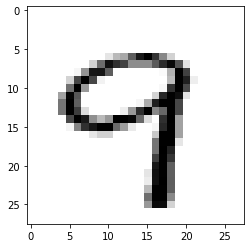

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

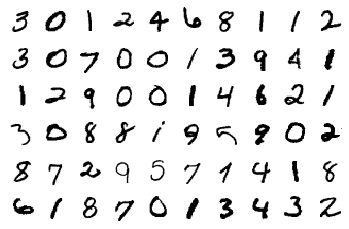

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
print("Check {0}",str("1+2"))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch,l1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  # https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if l1>0:
      reg_loss = 0 
      #l1_crit = nn.L1Loss(size_average=False)
      for param in model.parameters():
        #if param.dim()>1:
        reg_loss +=  torch.sum(abs(param))
        #reg_loss +=  param.norm(1)
        #reg_loss+=l1_crit(param)
      classify_loss = criterion(y_pred,target)
      #factor = 0.0005
      factor = l1
      loss = classify_loss + factor * reg_loss
      #loss += factor * reg_loss
    
    #train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    accuracy=100*correct/processed
    #train_acc.append(100*correct/processed)
    #return train_acc,train_losses
    return accuracy,loss


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    accuracy = 100. * correct / len(test_loader.dataset)
    #test_acc.append(100. * correct / len(test_loader.dataset))
    return accuracy,test_loss

# Let's Train and test our model`

In [0]:
def run_model(l1=0,l2=0):
  model_train_acc=[]
  model_train_losses=[]
  model_test_acc=[]
  model_test_losses=[]
  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=l2)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  EPOCHS = 40
  for epoch in range(EPOCHS):
    print("Epoch - ",epoch)
    train_acc,train_losses = train(model, device, train_loader, optimizer, epoch,l1)
    model_train_acc.append(train_acc)
    model_train_losses.append(train_losses)
    
    test_acc,test_loss = test(model, device, test_loader)
    model_test_acc.append(test_acc)
    model_test_losses.append(test_loss)
  return model_train_acc,model_train_losses,model_test_acc,model_test_losses

## Without L1 and L2

In [11]:
w_train_acc,w_train_loss,w_test_acc,w_test_loss = run_model()

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch -  0


Loss=2.3667569160461426 Batch_id=0 Accuracy=3.91:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3028, Accuracy: 1152/10000 (11.52%)

Epoch -  1


Loss=2.353729248046875 Batch_id=0 Accuracy=8.59:   0%|          | 0/469 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3032, Accuracy: 892/10000 (8.92%)

Epoch -  2


Loss=2.3171894550323486 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3035, Accuracy: 892/10000 (8.92%)

Epoch -  3


Loss=2.2812697887420654 Batch_id=0 Accuracy=15.62:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3037, Accuracy: 892/10000 (8.92%)

Epoch -  4


Loss=2.260965585708618 Batch_id=0 Accuracy=14.84:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3037, Accuracy: 892/10000 (8.92%)

Epoch -  5


Loss=2.1960692405700684 Batch_id=0 Accuracy=25.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3035, Accuracy: 892/10000 (8.92%)

Epoch -  6


Loss=2.0930607318878174 Batch_id=0 Accuracy=33.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3031, Accuracy: 1865/10000 (18.65%)

Epoch -  7


Loss=2.0661301612854004 Batch_id=0 Accuracy=37.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3030, Accuracy: 1135/10000 (11.35%)

Epoch -  8


Loss=1.9715734720230103 Batch_id=0 Accuracy=46.88:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3031, Accuracy: 1135/10000 (11.35%)

Epoch -  9


Loss=1.9260514974594116 Batch_id=0 Accuracy=51.56:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3035, Accuracy: 1135/10000 (11.35%)

Epoch -  10


Loss=1.8948323726654053 Batch_id=0 Accuracy=48.44:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3040, Accuracy: 1135/10000 (11.35%)

Epoch -  11


Loss=1.8004964590072632 Batch_id=0 Accuracy=58.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3042, Accuracy: 1135/10000 (11.35%)

Epoch -  12


Loss=1.7874603271484375 Batch_id=0 Accuracy=61.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3044, Accuracy: 1135/10000 (11.35%)

Epoch -  13


Loss=1.670351266860962 Batch_id=0 Accuracy=63.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3039, Accuracy: 1135/10000 (11.35%)

Epoch -  14


Loss=1.695333480834961 Batch_id=0 Accuracy=64.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 1135/10000 (11.35%)

Epoch -  15


Loss=1.6032958030700684 Batch_id=0 Accuracy=74.22:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2987, Accuracy: 1135/10000 (11.35%)

Epoch -  16


Loss=1.598961591720581 Batch_id=0 Accuracy=67.97:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2945, Accuracy: 1135/10000 (11.35%)

Epoch -  17


Loss=1.532533049583435 Batch_id=0 Accuracy=67.19:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2877, Accuracy: 1135/10000 (11.35%)

Epoch -  18


Loss=1.5109586715698242 Batch_id=0 Accuracy=68.75:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2843, Accuracy: 1135/10000 (11.35%)

Epoch -  19


Loss=1.546929955482483 Batch_id=0 Accuracy=68.75:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2683, Accuracy: 1145/10000 (11.45%)

Epoch -  20


Loss=1.3921362161636353 Batch_id=0 Accuracy=78.91:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2275, Accuracy: 1223/10000 (12.23%)

Epoch -  21


Loss=1.5043150186538696 Batch_id=0 Accuracy=71.88:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1248, Accuracy: 1643/10000 (16.43%)

Epoch -  22


Loss=1.3994548320770264 Batch_id=0 Accuracy=75.00:   0%|          | 0/469 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.9546, Accuracy: 2905/10000 (29.05%)

Epoch -  23


Loss=1.3143296241760254 Batch_id=0 Accuracy=89.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7971, Accuracy: 4659/10000 (46.59%)

Epoch -  24


Loss=1.36576247215271 Batch_id=0 Accuracy=77.34:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6334, Accuracy: 6515/10000 (65.15%)

Epoch -  25


Loss=1.376771330833435 Batch_id=0 Accuracy=81.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5147, Accuracy: 7409/10000 (74.09%)

Epoch -  26


Loss=1.3210171461105347 Batch_id=0 Accuracy=83.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4295, Accuracy: 7818/10000 (78.18%)

Epoch -  27


Loss=1.2722296714782715 Batch_id=0 Accuracy=83.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3581, Accuracy: 8131/10000 (81.31%)

Epoch -  28


Loss=1.2189124822616577 Batch_id=0 Accuracy=87.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3016, Accuracy: 8303/10000 (83.03%)

Epoch -  29


Loss=1.2069189548492432 Batch_id=0 Accuracy=86.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2529, Accuracy: 8456/10000 (84.56%)

Epoch -  30


Loss=1.2484524250030518 Batch_id=0 Accuracy=82.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2267, Accuracy: 8492/10000 (84.92%)

Epoch -  31


Loss=1.284733772277832 Batch_id=0 Accuracy=81.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2317, Accuracy: 8404/10000 (84.04%)

Epoch -  32


Loss=1.2176754474639893 Batch_id=0 Accuracy=86.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2280, Accuracy: 8285/10000 (82.85%)

Epoch -  33


Loss=1.119650959968567 Batch_id=0 Accuracy=87.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2414, Accuracy: 8001/10000 (80.01%)

Epoch -  34


Loss=1.1268231868743896 Batch_id=0 Accuracy=83.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2193, Accuracy: 7970/10000 (79.70%)

Epoch -  35


Loss=1.1225368976593018 Batch_id=0 Accuracy=87.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2146, Accuracy: 7863/10000 (78.63%)

Epoch -  36


Loss=1.1479853391647339 Batch_id=0 Accuracy=85.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1484, Accuracy: 8229/10000 (82.29%)

Epoch -  37


Loss=1.038003921508789 Batch_id=0 Accuracy=90.62:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0655, Accuracy: 8550/10000 (85.50%)

Epoch -  38


Loss=1.0125943422317505 Batch_id=0 Accuracy=88.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9842, Accuracy: 8800/10000 (88.00%)

Epoch -  39


Loss=0.9449836015701294 Batch_id=0 Accuracy=90.62:   0%|          | 0/469 [00:00<?, ?it/s]



Test set: Average loss: 0.9099, Accuracy: 8952/10000 (89.52%)



Text(0.5, 1.0, 'Test Accuracy')

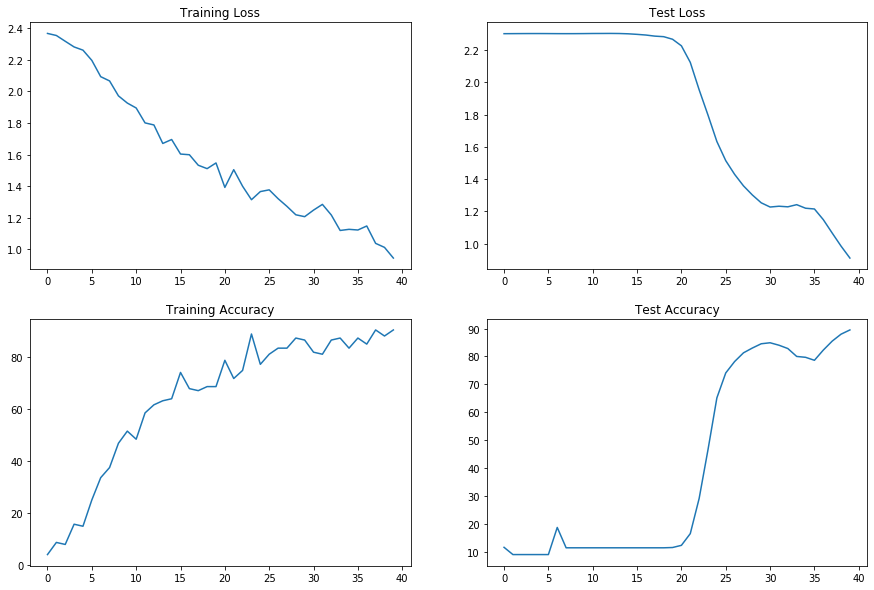

In [12]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(w_train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(w_train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(w_test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(w_test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
print("Train Loss",w_train_loss)
print("Train Accu",w_train_acc)
print("Test Loss",w_test_loss)
print("Test Accu",w_test_acc)

Train Loss [tensor(2.3668, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.3537, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.3172, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2813, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2610, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1961, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0931, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0661, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9716, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9261, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8948, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8005, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7875, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6704, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6953, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6033, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.5990, device='cuda:

In [0]:
import numpy as np
def find_misclassified(model, num_img=25):
  images=[]
  targ_list=[]
  pred_list=[]
  count=0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True).view_as(target)
      for d, t, p in zip(data, target, pred):
        if t!=p:
          d=d.cpu().numpy()
          t=t.cpu().numpy()
          p=p.cpu().numpy()
          d=(d*0.3081)+0.1307 #denormalizing each image before inserting
          images.append(d)
          targ_list.append(t)
          pred_list.append(p)
          count+=1
        if count==num_img:
          return images, targ_list, pred_list

def plot_misclassified(images, targ_list, pred_list, num_img=25, save=False):
  fig = plt.figure(figsize=(15,((num_img//5)+1)*3))
  for i in range(0, num_img):
    ax=fig.add_subplot((num_img//5)+1, 5, i+1)
    ax.imshow(np.rollaxis(img[i],0,3).squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title("Actual : "+str(targ_list[i])+"  Predicted : "+str(pred_list[i]))
  if save==True:
    plt.savefig('fig.png')
  plt.show()

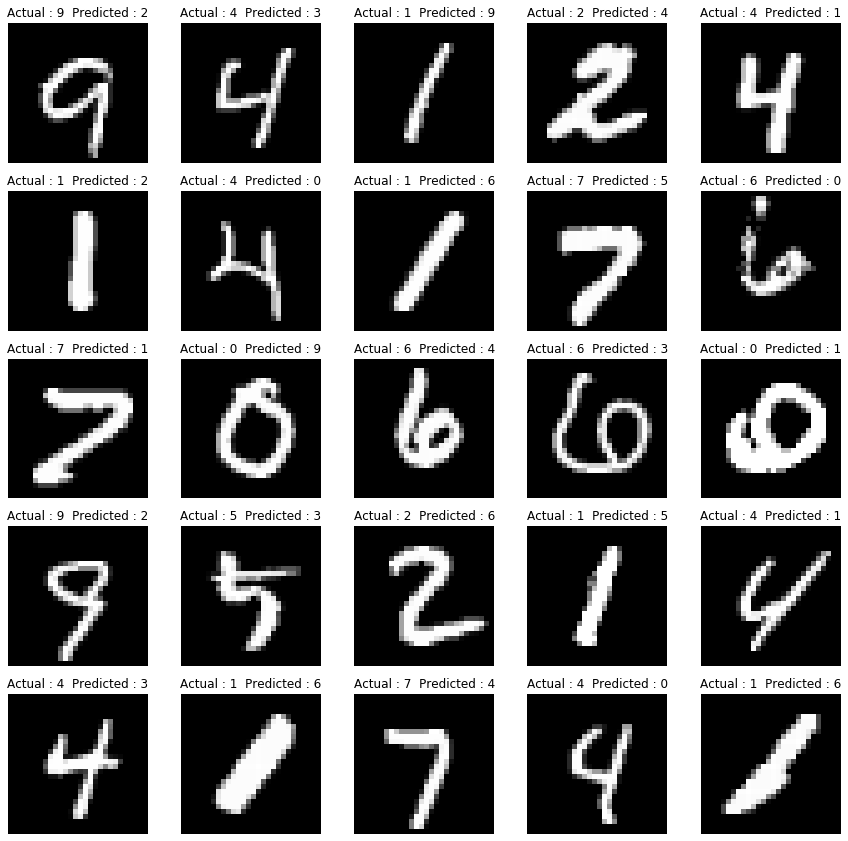

In [17]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

## With L1

In [18]:
l1_train_acc,l1_train_loss,l1_test_acc,l1_test_loss = run_model(l1=0.000001)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch -  0


Loss=2.361530303955078 Batch_id=0 Accuracy=5.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 1031/10000 (10.31%)

Epoch -  1


Loss=2.3414578437805176 Batch_id=0 Accuracy=10.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 1028/10000 (10.28%)

Epoch -  2


Loss=2.292109966278076 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3019, Accuracy: 1029/10000 (10.29%)

Epoch -  3


Loss=2.2094993591308594 Batch_id=0 Accuracy=13.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3012, Accuracy: 1028/10000 (10.28%)

Epoch -  4


Loss=2.144554615020752 Batch_id=0 Accuracy=27.34:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3000, Accuracy: 1051/10000 (10.51%)

Epoch -  5


Loss=2.0630905628204346 Batch_id=0 Accuracy=39.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2977, Accuracy: 1205/10000 (12.05%)

Epoch -  6


Loss=1.998010277748108 Batch_id=0 Accuracy=48.44:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2930, Accuracy: 1504/10000 (15.04%)

Epoch -  7


Loss=1.9608876705169678 Batch_id=0 Accuracy=42.97:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2839, Accuracy: 1775/10000 (17.75%)

Epoch -  8


Loss=1.8389393091201782 Batch_id=0 Accuracy=58.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2688, Accuracy: 2456/10000 (24.56%)

Epoch -  9


Loss=1.8451753854751587 Batch_id=0 Accuracy=53.12:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2475, Accuracy: 3119/10000 (31.19%)

Epoch -  10


Loss=1.8073519468307495 Batch_id=0 Accuracy=53.12:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2220, Accuracy: 3371/10000 (33.71%)

Epoch -  11


Loss=1.6950750350952148 Batch_id=0 Accuracy=67.97:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1930, Accuracy: 3621/10000 (36.21%)

Epoch -  12


Loss=1.6865595579147339 Batch_id=0 Accuracy=67.19:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1600, Accuracy: 3820/10000 (38.20%)

Epoch -  13


Loss=1.6280323266983032 Batch_id=0 Accuracy=64.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1204, Accuracy: 4105/10000 (41.05%)

Epoch -  14


Loss=1.5586684942245483 Batch_id=0 Accuracy=72.66:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0751, Accuracy: 4328/10000 (43.28%)

Epoch -  15


Loss=1.5860404968261719 Batch_id=0 Accuracy=65.62:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0289, Accuracy: 4494/10000 (44.94%)

Epoch -  16


Loss=1.5179706811904907 Batch_id=0 Accuracy=71.88:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.9749, Accuracy: 4737/10000 (47.37%)

Epoch -  17


Loss=1.4496285915374756 Batch_id=0 Accuracy=75.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.9259, Accuracy: 4890/10000 (48.90%)

Epoch -  18


Loss=1.4302119016647339 Batch_id=0 Accuracy=75.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8793, Accuracy: 4971/10000 (49.71%)

Epoch -  19


Loss=1.3587180376052856 Batch_id=0 Accuracy=78.12:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8297, Accuracy: 5154/10000 (51.54%)

Epoch -  20


Loss=1.3954907655715942 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7897, Accuracy: 5237/10000 (52.37%)

Epoch -  21


Loss=1.4175516366958618 Batch_id=0 Accuracy=71.88:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7479, Accuracy: 5339/10000 (53.39%)

Epoch -  22


Loss=1.435724139213562 Batch_id=0 Accuracy=72.66:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7044, Accuracy: 5462/10000 (54.62%)

Epoch -  23


Loss=1.3619471788406372 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6653, Accuracy: 5607/10000 (56.07%)

Epoch -  24


Loss=1.3310084342956543 Batch_id=0 Accuracy=75.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6263, Accuracy: 5763/10000 (57.63%)

Epoch -  25


Loss=1.2902225255966187 Batch_id=0 Accuracy=83.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5895, Accuracy: 5924/10000 (59.24%)

Epoch -  26


Loss=1.276643991470337 Batch_id=0 Accuracy=82.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5526, Accuracy: 6099/10000 (60.99%)

Epoch -  27


Loss=1.2355114221572876 Batch_id=0 Accuracy=82.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4985, Accuracy: 6470/10000 (64.70%)

Epoch -  28


Loss=1.262647032737732 Batch_id=0 Accuracy=85.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4442, Accuracy: 6784/10000 (67.84%)

Epoch -  29


Loss=1.192551851272583 Batch_id=0 Accuracy=82.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3875, Accuracy: 7180/10000 (71.80%)

Epoch -  30


Loss=1.1791523694992065 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3284, Accuracy: 7522/10000 (75.22%)

Epoch -  31


Loss=1.132724642753601 Batch_id=0 Accuracy=82.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2780, Accuracy: 7745/10000 (77.45%)

Epoch -  32


Loss=1.1617447137832642 Batch_id=0 Accuracy=85.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2393, Accuracy: 7904/10000 (79.04%)

Epoch -  33


Loss=1.126274824142456 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1878, Accuracy: 8141/10000 (81.41%)

Epoch -  34


Loss=1.172536015510559 Batch_id=0 Accuracy=83.59:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1429, Accuracy: 8320/10000 (83.20%)

Epoch -  35


Loss=1.0905648469924927 Batch_id=0 Accuracy=85.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1107, Accuracy: 8448/10000 (84.48%)

Epoch -  36


Loss=0.9954986572265625 Batch_id=0 Accuracy=89.84:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0893, Accuracy: 8489/10000 (84.89%)

Epoch -  37


Loss=1.0654771327972412 Batch_id=0 Accuracy=89.84:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0890, Accuracy: 8434/10000 (84.34%)

Epoch -  38


Loss=1.0328401327133179 Batch_id=0 Accuracy=91.41:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0867, Accuracy: 8369/10000 (83.69%)

Epoch -  39


Loss=1.009238600730896 Batch_id=0 Accuracy=85.16:   0%|          | 0/469 [00:00<?, ?it/s]



Test set: Average loss: 1.0805, Accuracy: 8330/10000 (83.30%)



Text(0.5, 1.0, 'Test Accuracy')

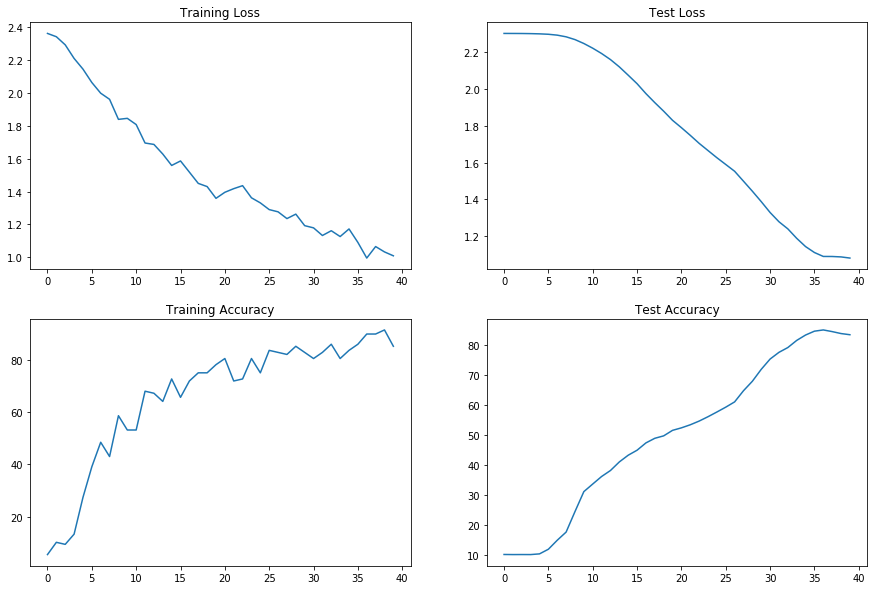

In [19]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(l1_train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(l1_train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(l1_test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(l1_test_acc)
axs[1, 1].set_title("Test Accuracy")

In [20]:
print("Train Loss",l1_train_loss)
print("Train Accu",l1_train_acc)
print("Test Loss",l1_test_loss)
print("Test Accu",l1_test_acc)

Train Loss [tensor(2.3615, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.3415, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.2921, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.2095, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.1446, device='cuda:0', grad_fn=<AddBackward0>), tensor(2.0631, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.9980, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.9609, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8389, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8452, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.8074, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6951, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6866, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.6280, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5587, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5860, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.5180, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.4496, devi

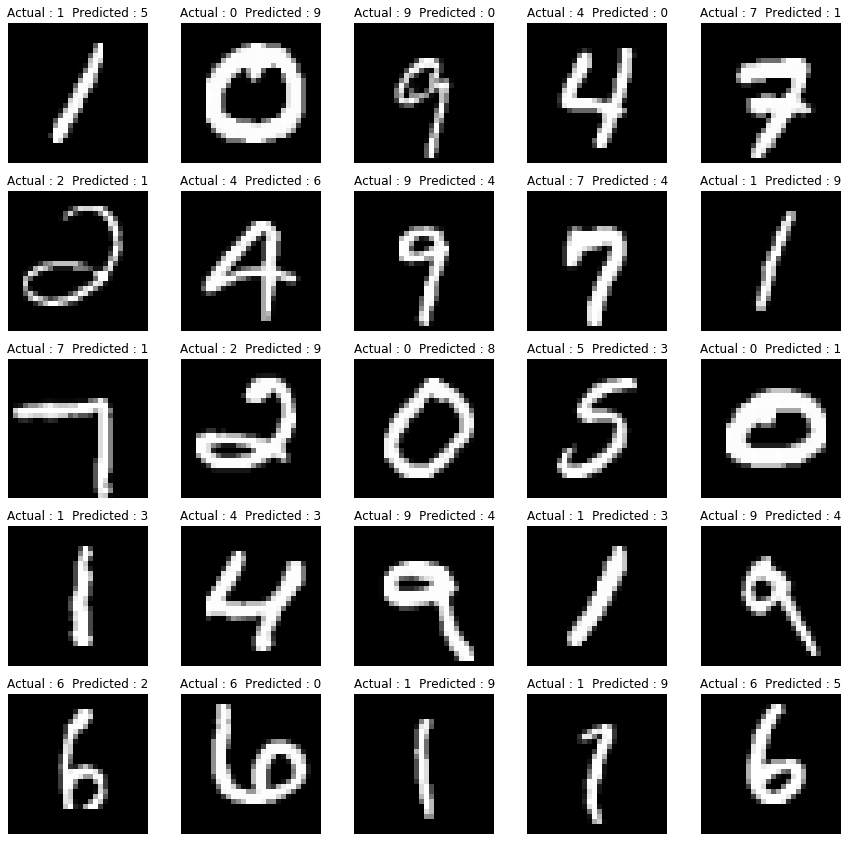

In [21]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

## With L2

In [22]:
l2_train_acc,l2_train_loss,l2_test_acc,l2_test_loss = run_model(l2=0.000001)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch -  0


Loss=2.3334619998931885 Batch_id=0 Accuracy=13.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1009/10000 (10.09%)

Epoch -  1


Loss=2.3055341243743896 Batch_id=0 Accuracy=10.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1009/10000 (10.09%)

Epoch -  2


Loss=2.2465739250183105 Batch_id=0 Accuracy=14.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1009/10000 (10.09%)

Epoch -  3


Loss=2.231548309326172 Batch_id=0 Accuracy=16.41:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 1009/10000 (10.09%)

Epoch -  4


Loss=2.1505274772644043 Batch_id=0 Accuracy=25.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 1011/10000 (10.11%)

Epoch -  5


Loss=2.07909893989563 Batch_id=0 Accuracy=31.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3023, Accuracy: 1028/10000 (10.28%)

Epoch -  6


Loss=2.056285858154297 Batch_id=0 Accuracy=35.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10.28%)

Epoch -  7


Loss=1.963043451309204 Batch_id=0 Accuracy=40.62:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3015, Accuracy: 1028/10000 (10.28%)

Epoch -  8


Loss=1.921907663345337 Batch_id=0 Accuracy=37.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10.28%)

Epoch -  9


Loss=1.8732739686965942 Batch_id=0 Accuracy=50.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1028/10000 (10.28%)

Epoch -  10


Loss=1.8948798179626465 Batch_id=0 Accuracy=48.44:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3045, Accuracy: 1028/10000 (10.28%)

Epoch -  11


Loss=1.7979249954223633 Batch_id=0 Accuracy=54.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3078, Accuracy: 1028/10000 (10.28%)

Epoch -  12


Loss=1.77870512008667 Batch_id=0 Accuracy=54.69:   0%|          | 0/469 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3111, Accuracy: 1133/10000 (11.33%)

Epoch -  13


Loss=1.783555269241333 Batch_id=0 Accuracy=51.56:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3133, Accuracy: 2008/10000 (20.08%)

Epoch -  14


Loss=1.7739028930664062 Batch_id=0 Accuracy=50.78:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3126, Accuracy: 2066/10000 (20.66%)

Epoch -  15


Loss=1.6633491516113281 Batch_id=0 Accuracy=61.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3015, Accuracy: 2037/10000 (20.37%)

Epoch -  16


Loss=1.685545563697815 Batch_id=0 Accuracy=57.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2840, Accuracy: 2019/10000 (20.19%)

Epoch -  17


Loss=1.5958943367004395 Batch_id=0 Accuracy=72.66:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2545, Accuracy: 2183/10000 (21.83%)

Epoch -  18


Loss=1.6668767929077148 Batch_id=0 Accuracy=65.62:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2174, Accuracy: 2398/10000 (23.98%)

Epoch -  19


Loss=1.5629451274871826 Batch_id=0 Accuracy=70.31:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1665, Accuracy: 2549/10000 (25.49%)

Epoch -  20


Loss=1.5633457899093628 Batch_id=0 Accuracy=66.41:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1016, Accuracy: 2726/10000 (27.26%)

Epoch -  21


Loss=1.5062975883483887 Batch_id=0 Accuracy=71.09:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0256, Accuracy: 2908/10000 (29.08%)

Epoch -  22


Loss=1.5006757974624634 Batch_id=0 Accuracy=69.53:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.9445, Accuracy: 3137/10000 (31.37%)

Epoch -  23


Loss=1.4318101406097412 Batch_id=0 Accuracy=71.09:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8453, Accuracy: 3553/10000 (35.53%)

Epoch -  24


Loss=1.4148950576782227 Batch_id=0 Accuracy=75.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7285, Accuracy: 4424/10000 (44.24%)

Epoch -  25


Loss=1.3640451431274414 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6024, Accuracy: 5299/10000 (52.99%)

Epoch -  26


Loss=1.311238169670105 Batch_id=0 Accuracy=74.22:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4977, Accuracy: 5797/10000 (57.97%)

Epoch -  27


Loss=1.3007855415344238 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4234, Accuracy: 6120/10000 (61.20%)

Epoch -  28


Loss=1.358852505683899 Batch_id=0 Accuracy=75.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3516, Accuracy: 6534/10000 (65.34%)

Epoch -  29


Loss=1.2675530910491943 Batch_id=0 Accuracy=78.12:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2826, Accuracy: 7111/10000 (71.11%)

Epoch -  30


Loss=1.248227596282959 Batch_id=0 Accuracy=79.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2254, Accuracy: 7449/10000 (74.49%)

Epoch -  31


Loss=1.218666672706604 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1841, Accuracy: 7610/10000 (76.10%)

Epoch -  32


Loss=1.1767257452011108 Batch_id=0 Accuracy=79.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1452, Accuracy: 7733/10000 (77.33%)

Epoch -  33


Loss=1.1902204751968384 Batch_id=0 Accuracy=77.34:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1180, Accuracy: 7761/10000 (77.61%)

Epoch -  34


Loss=1.1360151767730713 Batch_id=0 Accuracy=82.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0963, Accuracy: 7758/10000 (77.58%)

Epoch -  35


Loss=1.035967469215393 Batch_id=0 Accuracy=84.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0609, Accuracy: 7824/10000 (78.24%)

Epoch -  36


Loss=1.0350382328033447 Batch_id=0 Accuracy=84.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0326, Accuracy: 7950/10000 (79.50%)

Epoch -  37


Loss=1.0914924144744873 Batch_id=0 Accuracy=82.03:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0101, Accuracy: 8067/10000 (80.67%)

Epoch -  38


Loss=1.0333666801452637 Batch_id=0 Accuracy=85.16:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9916, Accuracy: 8204/10000 (82.04%)

Epoch -  39


Loss=1.031326413154602 Batch_id=0 Accuracy=85.94:   0%|          | 0/469 [00:00<?, ?it/s]



Test set: Average loss: 0.9627, Accuracy: 8349/10000 (83.49%)



Text(0.5, 1.0, 'Test Accuracy')

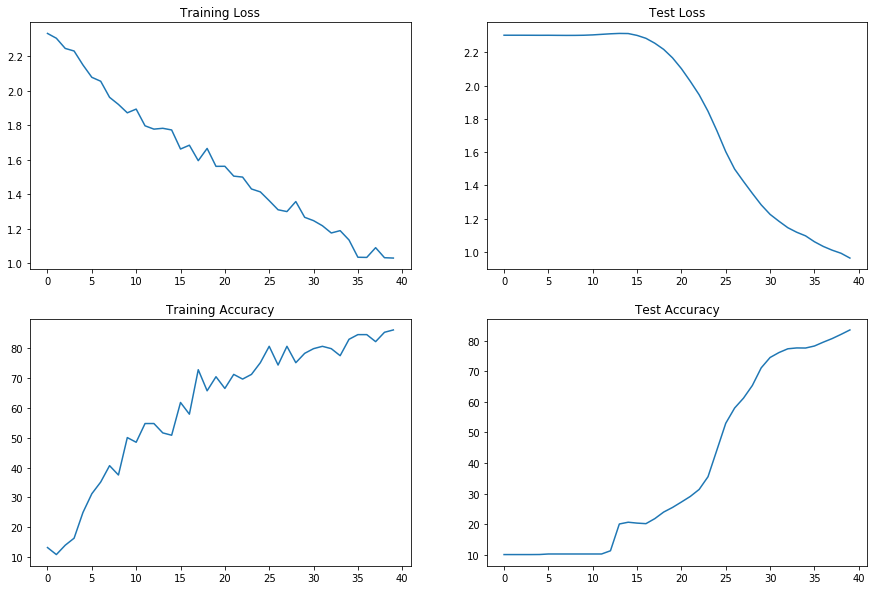

In [23]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(l2_train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(l2_train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(l2_test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(l2_test_acc)
axs[1, 1].set_title("Test Accuracy")

In [24]:
print("Train Loss",l2_train_loss)
print("Train Accu",l2_train_acc)
print("Test Loss",l2_test_loss)
print("Test Accu",l2_test_acc)

Train Loss [tensor(2.3335, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.3055, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2466, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2315, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1505, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0791, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0563, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9630, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9219, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8733, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8949, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7979, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7787, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7836, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.7739, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6633, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.6855, device='cuda:

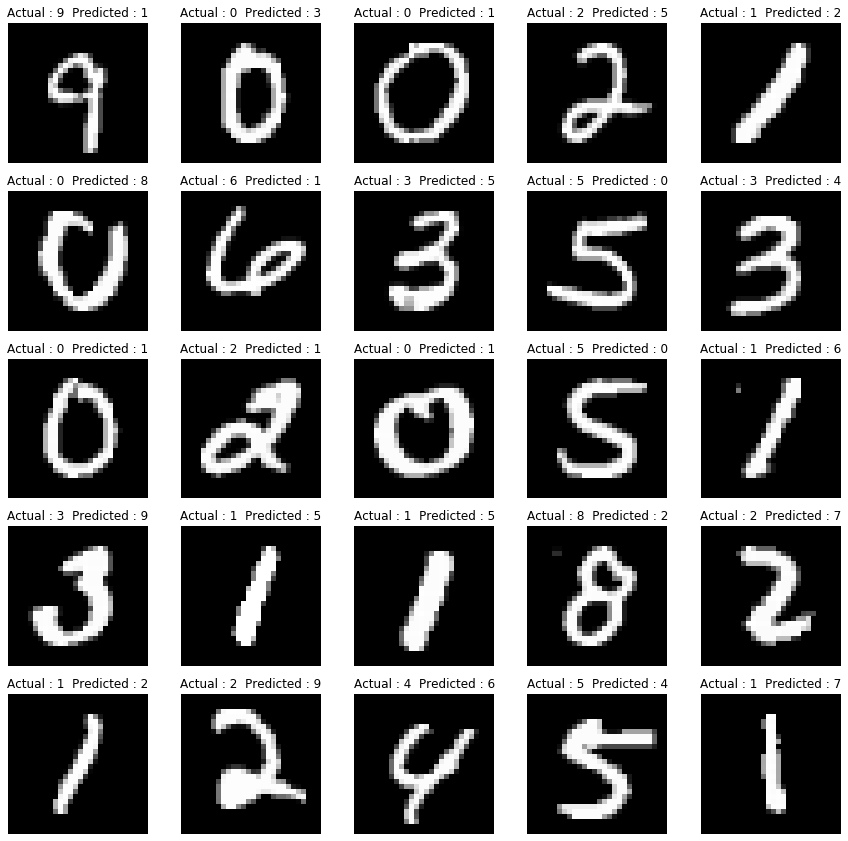

In [25]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

## With L1 and L2

In [26]:
l12_train_acc,l12_train_loss,l12_test_acc,l12_test_loss = run_model(l1=0.000001,l2=0.000001)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch -  0


Loss=2.295003890991211 Batch_id=0 Accuracy=13.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3025, Accuracy: 1028/10000 (10.28%)

Epoch -  1


Loss=2.351454496383667 Batch_id=0 Accuracy=6.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10.28%)

Epoch -  2


Loss=2.3090779781341553 Batch_id=0 Accuracy=10.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3028, Accuracy: 1028/10000 (10.28%)

Epoch -  3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3029, Accuracy: 1028/10000 (10.28%)

Epoch -  4


Loss=2.2041704654693604 Batch_id=0 Accuracy=25.00:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3031, Accuracy: 1028/10000 (10.28%)

Epoch -  5


Loss=2.1889004707336426 Batch_id=0 Accuracy=29.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3033, Accuracy: 1028/10000 (10.28%)

Epoch -  6


Loss=2.1356699466705322 Batch_id=0 Accuracy=35.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3033, Accuracy: 1028/10000 (10.28%)

Epoch -  7


Loss=2.070551633834839 Batch_id=0 Accuracy=41.41:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3033, Accuracy: 1028/10000 (10.28%)

Epoch -  8


Loss=2.0440213680267334 Batch_id=0 Accuracy=48.44:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3031, Accuracy: 1028/10000 (10.28%)

Epoch -  9


Loss=1.939383625984192 Batch_id=0 Accuracy=55.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3027, Accuracy: 1028/10000 (10.28%)

Epoch -  10


Loss=1.9444003105163574 Batch_id=0 Accuracy=46.88:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10.28%)

Epoch -  11


Loss=1.814475655555725 Batch_id=0 Accuracy=63.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2995, Accuracy: 1118/10000 (11.18%)

Epoch -  12


Loss=1.8077975511550903 Batch_id=0 Accuracy=60.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2946, Accuracy: 2058/10000 (20.58%)

Epoch -  13


Loss=1.73417067527771 Batch_id=0 Accuracy=72.66:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2867, Accuracy: 2122/10000 (21.22%)

Epoch -  14


Loss=1.7507976293563843 Batch_id=0 Accuracy=60.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2742, Accuracy: 2095/10000 (20.95%)

Epoch -  15


Loss=1.6486481428146362 Batch_id=0 Accuracy=76.56:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2554, Accuracy: 2073/10000 (20.73%)

Epoch -  16


Loss=1.6648868322372437 Batch_id=0 Accuracy=70.31:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2276, Accuracy: 2491/10000 (24.91%)

Epoch -  17


Loss=1.6182323694229126 Batch_id=0 Accuracy=69.53:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1900, Accuracy: 2711/10000 (27.11%)

Epoch -  18


Loss=1.5489826202392578 Batch_id=0 Accuracy=71.88:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1478, Accuracy: 2767/10000 (27.67%)

Epoch -  19


Loss=1.535031795501709 Batch_id=0 Accuracy=76.56:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0990, Accuracy: 2809/10000 (28.09%)

Epoch -  20


Loss=1.4561207294464111 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0370, Accuracy: 2969/10000 (29.69%)

Epoch -  21


Loss=1.4726629257202148 Batch_id=0 Accuracy=74.22:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.9616, Accuracy: 3426/10000 (34.26%)

Epoch -  22


Loss=1.3390339612960815 Batch_id=0 Accuracy=86.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8765, Accuracy: 4185/10000 (41.85%)

Epoch -  23


Loss=1.3736190795898438 Batch_id=0 Accuracy=82.81:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7740, Accuracy: 5184/10000 (51.84%)

Epoch -  24


Loss=1.3857946395874023 Batch_id=0 Accuracy=81.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6762, Accuracy: 6086/10000 (60.86%)

Epoch -  25


Loss=1.332263708114624 Batch_id=0 Accuracy=84.38:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5763, Accuracy: 6861/10000 (68.61%)

Epoch -  26


Loss=1.3285584449768066 Batch_id=0 Accuracy=80.47:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4963, Accuracy: 7427/10000 (74.27%)

Epoch -  27


Loss=1.1980386972427368 Batch_id=0 Accuracy=92.19:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4283, Accuracy: 7737/10000 (77.37%)

Epoch -  28


Loss=1.3118433952331543 Batch_id=0 Accuracy=79.69:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3617, Accuracy: 7975/10000 (79.75%)

Epoch -  29


Loss=1.182223916053772 Batch_id=0 Accuracy=87.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3066, Accuracy: 8180/10000 (81.80%)

Epoch -  30


Loss=1.1478779315948486 Batch_id=0 Accuracy=88.28:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2577, Accuracy: 8376/10000 (83.76%)

Epoch -  31


Loss=1.0925661325454712 Batch_id=0 Accuracy=92.19:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1995, Accuracy: 8532/10000 (85.32%)

Epoch -  32


Loss=1.1132686138153076 Batch_id=0 Accuracy=89.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1314, Accuracy: 8650/10000 (86.50%)

Epoch -  33


Loss=1.1007544994354248 Batch_id=0 Accuracy=87.50:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0743, Accuracy: 8729/10000 (87.29%)

Epoch -  34


Loss=1.0472993850708008 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0231, Accuracy: 8766/10000 (87.66%)

Epoch -  35


Loss=1.0513819456100464 Batch_id=0 Accuracy=86.72:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9854, Accuracy: 8726/10000 (87.26%)

Epoch -  36


Loss=1.067751169204712 Batch_id=0 Accuracy=85.94:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9484, Accuracy: 8689/10000 (86.89%)

Epoch -  37


Loss=1.0027579069137573 Batch_id=0 Accuracy=89.06:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9192, Accuracy: 8746/10000 (87.46%)

Epoch -  38


Loss=1.090625524520874 Batch_id=0 Accuracy=81.25:   0%|          | 0/469 [00:00<?, ?it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8880, Accuracy: 8873/10000 (88.73%)

Epoch -  39


Loss=1.0733592510223389 Batch_id=0 Accuracy=84.38:   0%|          | 0/469 [00:00<?, ?it/s]



Test set: Average loss: 0.8732, Accuracy: 8892/10000 (88.92%)



Text(0.5, 1.0, 'Test Accuracy')

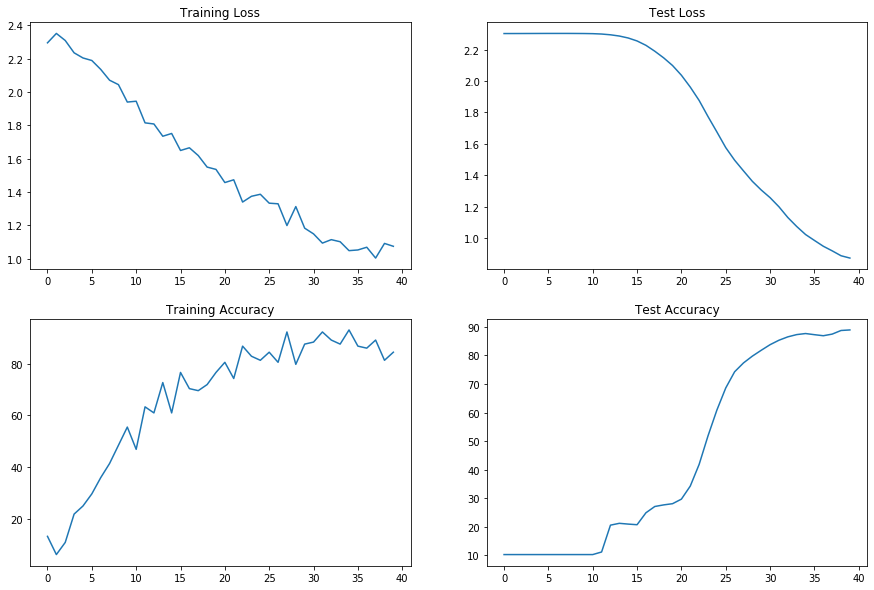

In [27]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(l12_train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(l12_train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(l12_test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(l12_test_acc)
axs[1, 1].set_title("Test Accuracy")

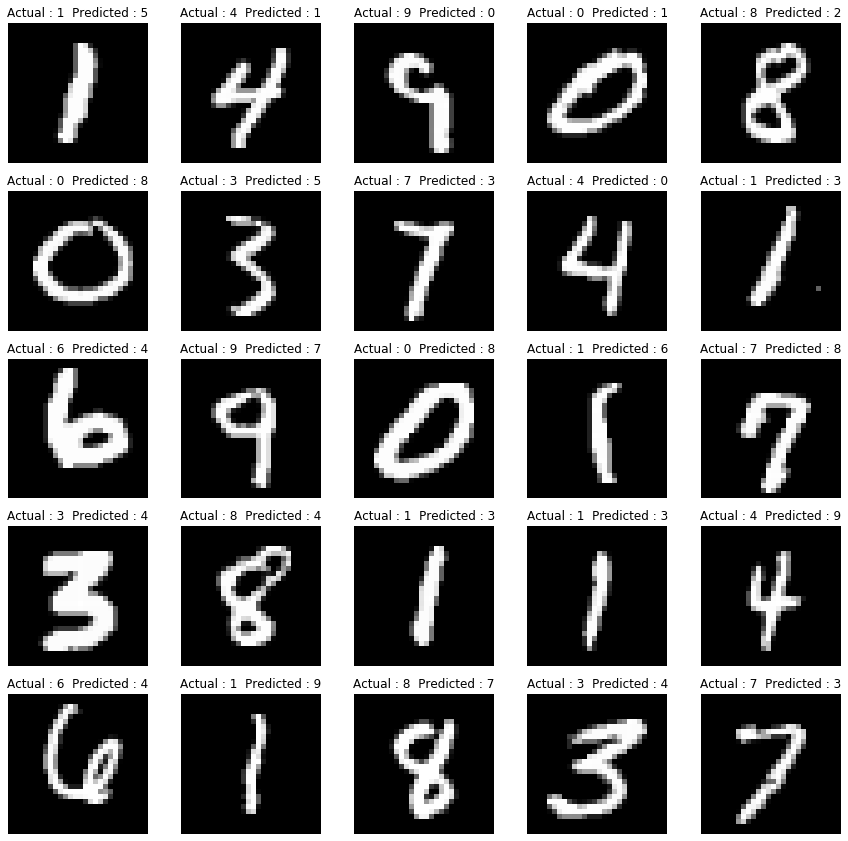

In [28]:
img, targ, pred = find_misclassified(model)
plot_misclassified(img, targ, pred)

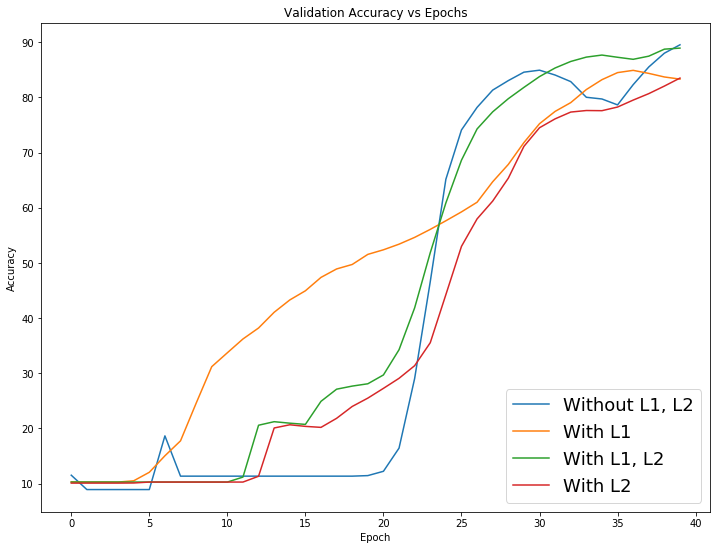

In [29]:
fig, axs = plt.subplots(1,1,figsize=(12,9))


axs.plot(w_test_acc, label='Without L1, L2')
axs.plot(l1_test_acc, label='With L1')
axs.plot(l12_test_acc, label='With L1, L2')
axs.plot(l2_test_acc, label='With L2')
axs.set_title("Validation Accuracy vs Epochs")
axs.set_xlabel("Epoch")
axs.set_ylabel("Accuracy")
axs.legend(loc='lower right', prop={'size': 18})

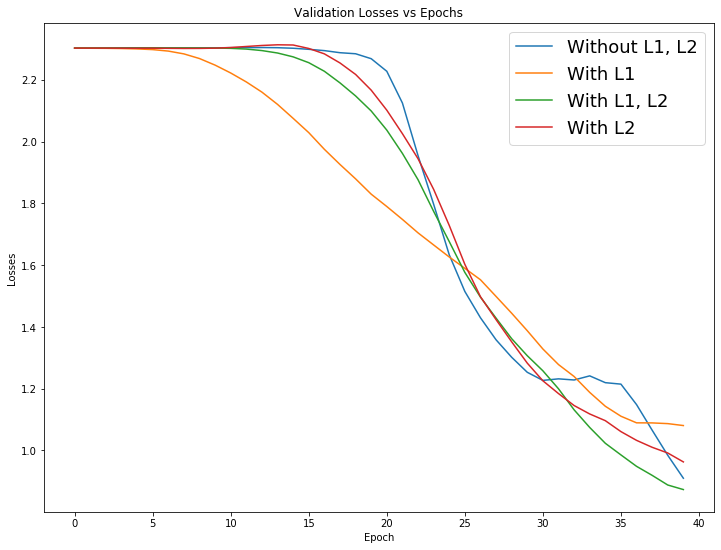

In [30]:
fig, axs = plt.subplots(1,1,figsize=(12,9))


axs.plot(w_test_loss, label='Without L1, L2')
axs.plot(l1_test_loss, label='With L1')
axs.plot(l12_test_loss, label='With L1, L2')
axs.plot(l2_test_loss, label='With L2')
axs.set_title("Validation Losses vs Epochs")
axs.set_xlabel("Epoch")
axs.set_ylabel("Losses")
axs.legend(loc='upper right', prop={'size': 18})